In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
%matplotlib inline

In [8]:
# Graph plotting function; only needed for visualisation
def plot_graph(G, ranks):
    graph = nx.DiGraph(np.array(G))
    fig = plt.figure(figsize=(10, 5))

    layout = nx.circular_layout(graph)
    node_opts = {"node_size": 2000, "node_color": "w", "edgecolors": "k", "linewidths": 2.0}
    edge_opts = {"connectionstyle": 'arc3,rad=0.1', "arrowsize": 20, }
    nx.draw(graph, pos=layout, with_labels=False, **node_opts, **edge_opts)
    node_names = [f"{n}" for n in graph.nodes()] # Numbers for names
    # node_names = [chr(65+(n % 25))+(chr(65+(n//25)) if n//25 else '') for n in graph.nodes()]  # Letters for names
    labels = {
        n: f"$\mathbf{{{node_names[n]}}} $\n{ranks[n]:.3f}" for n in graph.nodes()}
    nx.draw_networkx_labels(G, pos=layout, labels=labels)

# Problem 2: PageRank algorithm (3 pts out of 12)

### <div align="right"> &copy; Ostap Dyhdalovych & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   Nazar Andrushko
*   Roman Kovalchuk


---
## Introduction

#### The core idea of the PageRank algorithm is determining the popularity of each page on the Internet, i.e., the percentage of users reading the page at any given moment. Let us model the Internet surfing process of a randomly sampled user, who starts at a random page and at each step follows a random link to another site (chosen with equal probabilities from all available ones)

#### Then the probability that a user visits the website $u$ at a step $k$ is calculated as $r_{u, k} = \sum_{i\rightarrow u}\frac{r_{i, k-1}}{l_i}$ where $l_i$ is the number of outgoing links from the page $i$. Or, in  matrix form, $\mathbf{r}_k = L\mathbf{r}_{k-1}$, where $L$ is an adjacency matrix of the graph, with each column divided by it's sum; $L_{i, j}$ represents probability of going from the page $i$ to page $j$. We want to determine the equilibrium percentages, where $L\mathbf{r} = \mathbf{r}$

#### The equation above can be solved directly, but this is unfeasible for  large matrices. Instead, we can interpret $L$ as a Markov matrix; if it is regular, then subsequent iterations $\mathbf{r}_k = L\mathbf{r}_{k-1}$ will converge to the true solution $\mathbf{r}$

#### Note: you will be using the $\mathtt{networkx}$ library for graph representations and manipulations
---



## **1. Basic PageRank (0.5 pts)**
####Implement the basic PageRank algorithm below and test it on a simple graph. Do the results look intuitive? Test different initial rank distributions and iteration counts

In [9]:
def PageRank_1(G, num_steps=10, ranks=None):
    """
    Obtain transition probability matrix L from G. At each step, use L to calculate r(k) from r(k-1).

    Args:
        G: graph adjacency matrix; `np.array(n, n)`
        num_steps: number of iteratons, `int`
        ranks: initial page ranks; `np.array(n,)` or `None`
    Returns:
        r: ranks of each node in G; `np.array(n, )`
    """
    if ranks is None:
        ranks = np.ones(G.shape[0])/G.shape[0]
    assert G.shape[0] == G.shape[1]
    assert ranks.shape[0] == G.shape[0]
    # ====================
    out_degree = np.sum(G, axis=1, keepdims=True)
    L = G / out_degree

    # PageRank iteration
    for _ in range(num_steps):
        ranks = np.dot(L, ranks)
    # ====================
    return ranks

Initial Ranks: [0.33333333 0.33333333 0.33333333], Iteration Count: 5
Final Ranks: [0.33333333 0.33333333 0.33333333]
Initial Ranks: [0.33333333 0.33333333 0.33333333], Iteration Count: 10
Final Ranks: [0.33333333 0.33333333 0.33333333]
Initial Ranks: [0.33333333 0.33333333 0.33333333], Iteration Count: 15
Final Ranks: [0.33333333 0.33333333 0.33333333]
Initial Ranks: [0.50173592 0.07621941 0.91237013], Iteration Count: 5
Final Ranks: [0.3934965  0.39163622 0.49801534]
Initial Ranks: [0.50173592 0.07621941 0.91237013], Iteration Count: 10
Final Ranks: [0.40586375 0.41869607 0.41916114]
Initial Ranks: [0.50173592 0.07621941 0.91237013], Iteration Count: 15
Final Ranks: [0.41233804 0.41560426 0.41239618]


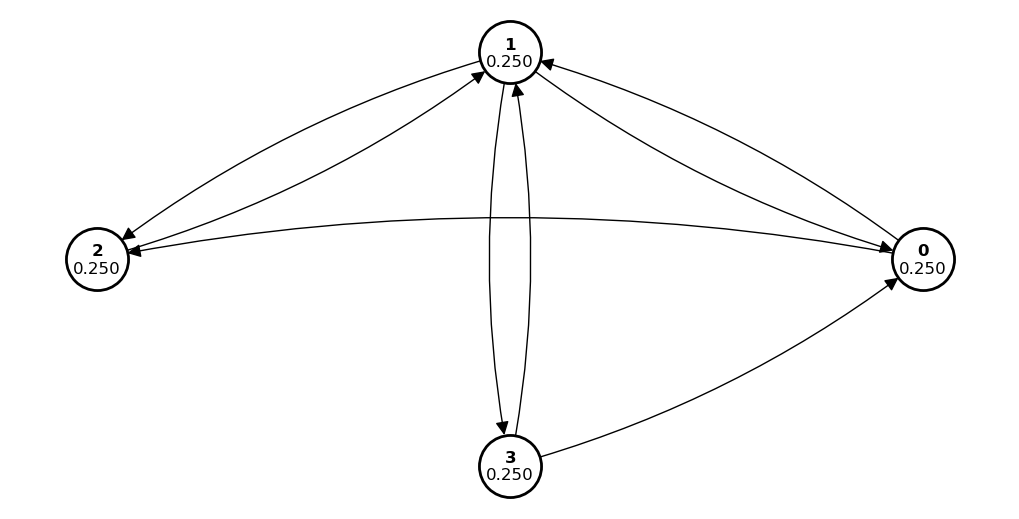

In [11]:
G = np.array([[0, 1, 1, 0],
              [1, 0, 1, 1],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]
plot_graph(G, ranks)

# ====================
G = np.array([[0, 1, 1], [1, 0, 0], [0, 1, 0]])

# Test different initial rank distributions and iteration counts
initial_ranks_list = [np.ones(G.shape[0]) / G.shape[0], np.random.rand(G.shape[0])]
iteration_counts = [5, 10, 15]

for initial_ranks in initial_ranks_list:
    for num_steps in iteration_counts:
        result_ranks = PageRank_1(G, num_steps=num_steps, ranks=initial_ranks)
        print(f"Initial Ranks: {initial_ranks}, Iteration Count: {num_steps}")
        print(f"Final Ranks: {result_ranks}")
        print("=" * 40)


---
#### **Summarize your findings here**
#### Summary
The method calculates of the transition probability matrix L by normalizing the adjacency matrix G based on the out-degree of each node.
PageRank is implemented as an iterative method using a loop that updates ranks through matrix multiplication with the transition probability matrix.

#### Findings:
In the PageRank algorithm initial uniform rank consistently converge to the final ranks with equal distribution irrespective of the iteration count.
However, when initialized with a non-uniform distribution, the final ranks evolve progressively with increasing iterations, making the algorithm sensitive to the initial rank distribution.

---

## **2. Fixing "dead end" nodes (0.8 pt)**

### **2.1 (0.4 pts)** How does the above algorithm work if there are nodes without outgoing links ("dead" nodes)?  


---

If there are nodes without outgoing links, "dead" nodes, the PageRank algorithm would face challenges.
These nodes could disrupt the proper distribution of rank scores to other nodes, as their rows in the transition probability matrix would be entirely composed of zeros.
To tackle this, it's possible to introduce a damping factor or deal with it explicitly in the algorithm.

---

###**2.2 (0.4 pts)**
#### The simplest solution in the case with "dead end" nodes is to add random jumps from them to any other node: $$L' = L + \mathbf{1}\mathbf{d}^\top/n,$$ where $\mathbf{1}$ is a vector of 1s, and $\mathbf{d}$ is a vector with ones at dead nodes and zeros otherwise.
####Modify the basic algorithm and test it on the graph below


[False False False  True]


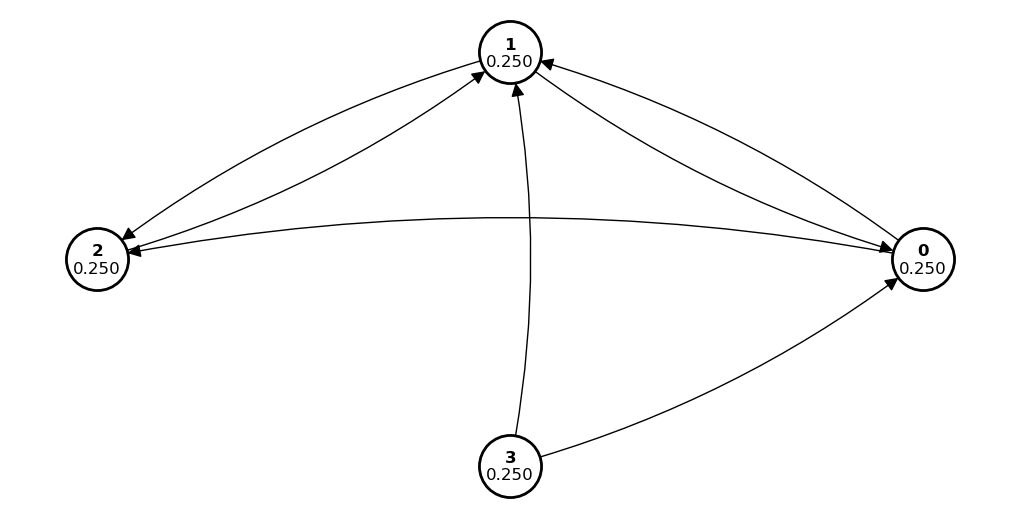

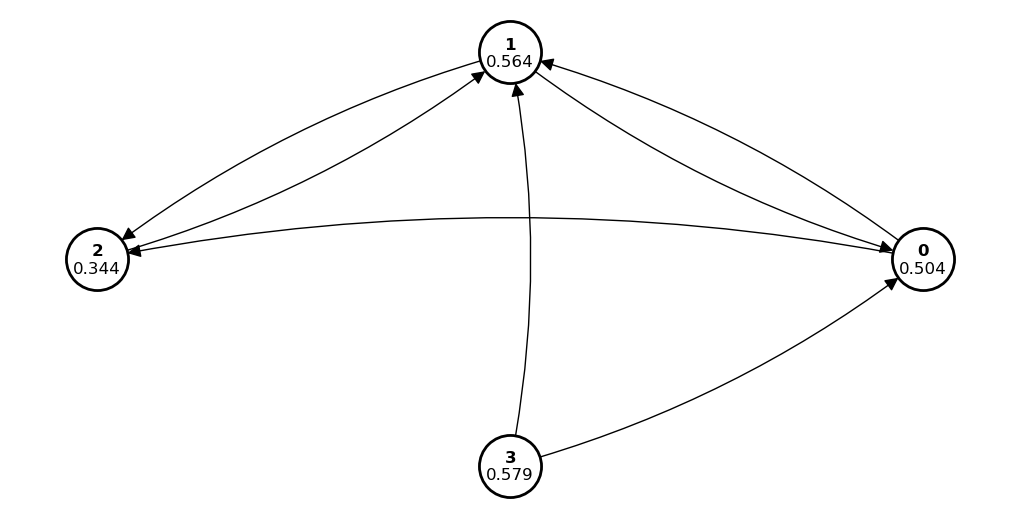

In [31]:
def PageRank_2(G, num_steps=10, ranks=None):
    """
    Add random jumps from dead nodes

    Args:
        G: graph adjacency matrix; `np.array(n, n)`
        num_steps: number of iteratons, `int`
        ranks: initial page ranks; `np.array(n,)` or `None`
    Returns:
        r: ranks of each node in G; `np.array(n, )`
    """
    if ranks is None:
        ranks = np.ones(G.shape[0])/G.shape[0]
    assert G.shape[0] == G.shape[1]
    assert ranks.shape[0] == G.shape[0]
    # ====================
    dead_nodes = np.sum(G, axis=0) == 0
    print(dead_nodes)

    # Transition probability matrix with random jumps from dead nodes
    P = G / (G.sum(axis=0) + 1e-20) + np.outer(np.ones(G.shape[0]) / G.shape[0], dead_nodes) / G.shape[0]

    P = P + np.outer(np.ones(G.shape[0]), dead_nodes) / G.shape[0]

    for i in range(num_steps):
        ranks = P.dot(ranks)
    # ====================
    return ranks

G = np.array([[0, 1, 1, 0],
              [1, 0, 1, 0],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]

plot_graph(G, ranks)

# ====================
ranks = PageRank_2(G, num_steps=10, ranks=ranks)

# Plot the graph with computed ranks
plot_graph(G, ranks)


##**3. Making the Markov chain regular (1.2 pts)**

###**3.1 (0.4 pts)**
#### Test the same algorithm on two slightly more specific graphs; try different initial rank distributions. Do the results still seem intuitive? What can be the problem?

[False False False False False False]


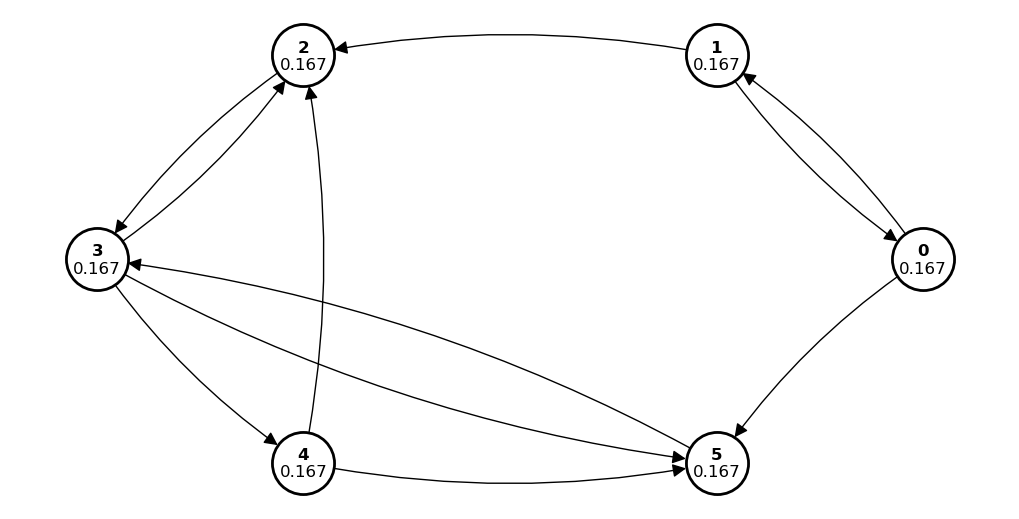

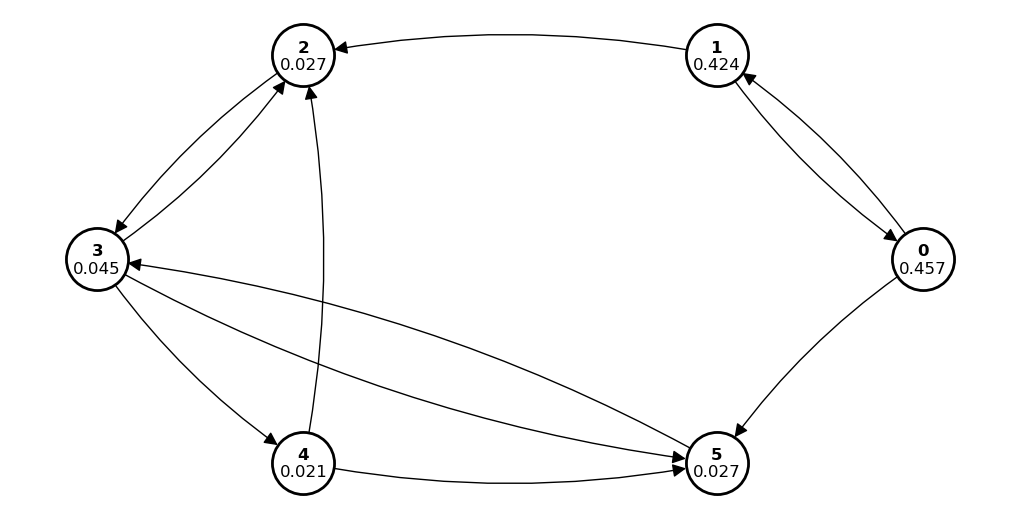

In [33]:
G = np.array([[0, 1, 0, 0, 0, 1],
              [1, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 1, 0, 1, 1],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0]])

ranks = np.ones(G.shape[0])/G.shape[0]
plot_graph(G, ranks)
# ====================
initial_ranks = np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.1])

# Test the algorithm on the first graph (G1)
ranks_G1 = PageRank_2(G, num_steps=10, ranks=initial_ranks)
plot_graph(G, ranks_G1)


[False False False False]


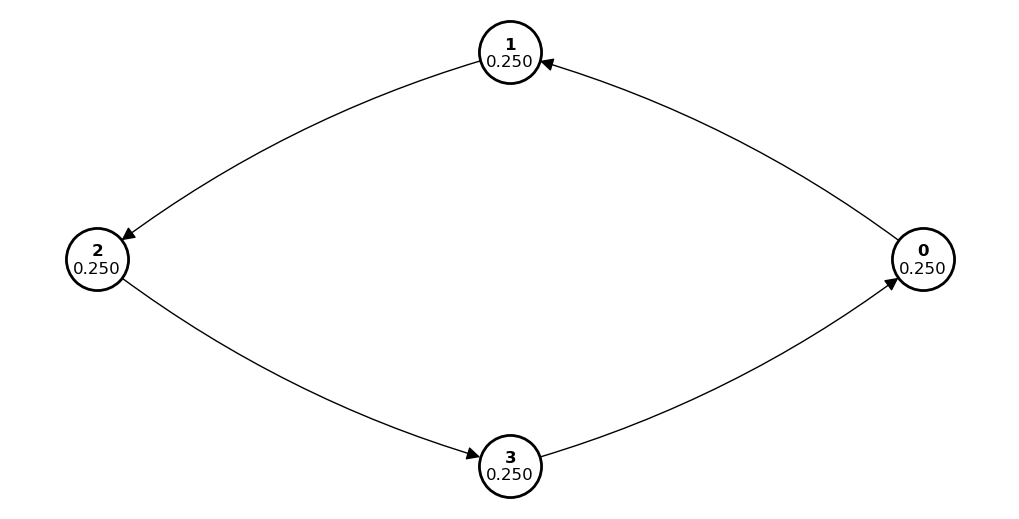

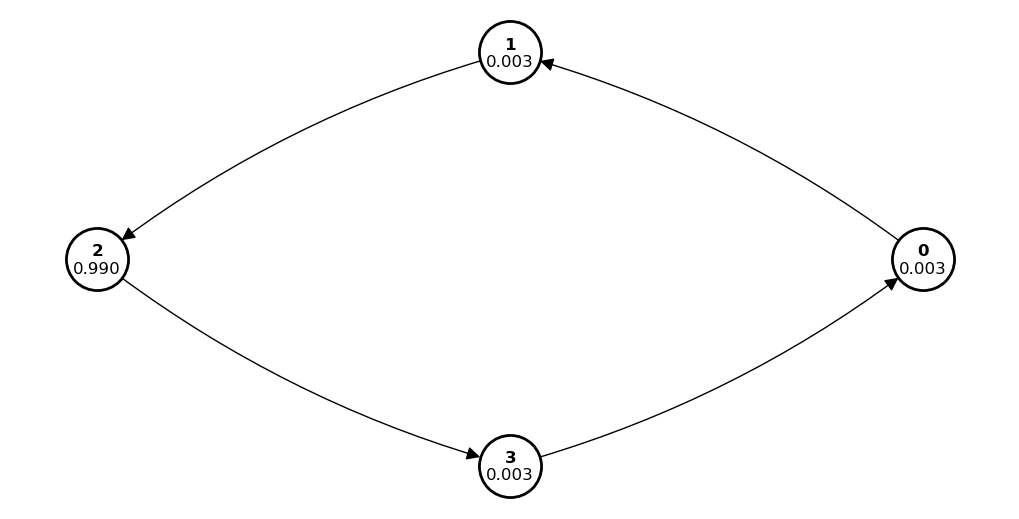

In [43]:
G = np.array([[0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1, 0, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]
plot_graph(G, ranks)
# ====================
initial_ranks = np.array([0.99, 0.0033, 0.0033, 0.0033])

# Test the algorithm on the first graph (G1)
ranks_G1 = PageRank_2(G, num_steps=10, ranks=initial_ranks)
plot_graph(G, ranks_G1)



---
####**Your explanations come here**

The choice of initial rank distribution influences the final PageRank scores.
Different initial rank distributions can lead to different convergence patterns.
The sensitivity to the initial distribution is one of the known characteristics of the PageRank algorithm.
For the last matrix, we can see if the initial matrix has only one connection to other nodes, the ranks remain the same (equal to the initial)

---

###**3.2 (0.4 pts)**
#### To remedy the above problems, a small probability of a random jump is added to every node (fresh start):  $$Q = (1 - \alpha) L' + \alpha\mathbf{1}\mathbf{1}^\top.$$ Show that this makes the matrix regular


---

The modification to the PageRank algorithm, expressed as $\(Q = (1 - \alpha) L' + \alpha\mathbf{1}\mathbf{1}^\top\)$, introduces a small probability of random jumps to every node.
This helps alleviate sensitivity to initial rank distributions and ensures convergence.
The combination of weighted transition probabilities and random jumps promotes matrix regularity, essential for the stability and effectiveness of the PageRank algorithm,
particularly in scenarios with specific initial distributions, single node connections or dead nodes.

---

###**3.3 (0.4 pts)**
####Implement this modification and test it on the same graphs. How does the choice of $\alpha$ influence the resulting ranks?

In [44]:
def PageRank_3(G, num_steps=10, ranks=None, alpha = 0.15, ):
    """
    Add random jumps from every node with probability `alpha`
    Args:
        G: graph adjacency matrix; `np.array(n, n)`
        num_steps: number of iteratons, `int`
        alpha: random jump probability, `float`
        ranks: initial page ranks; `np.array(n,)` or `None`
    Returns:
        r: ranks of each node in G; `np.array(n, )`
    """
    if ranks is None:
        ranks = np.ones(G.shape[0])/G.shape[0]
    assert G.shape[0] == G.shape[1]
    assert ranks.shape[0] == G.shape[0]
    # ====================
    P = G / (G.sum(axis=0) + 1e-20) + np.outer(np.ones(G.shape[0]) / G.shape[0], np.sum(G, axis=0) == 0) / G.shape[0]

    # Combine with the random jumps and damping factor
    Q = (1 - alpha) * P + alpha * np.outer(np.ones(G.shape[0]), np.ones(G.shape[0])) / G.shape[0]

    for i in range(num_steps):
        ranks = Q.dot(ranks)

    # ====================
    return ranks

'alpha is: '

0.1

'alpha is: '

0.33

'alpha is: '

0.6

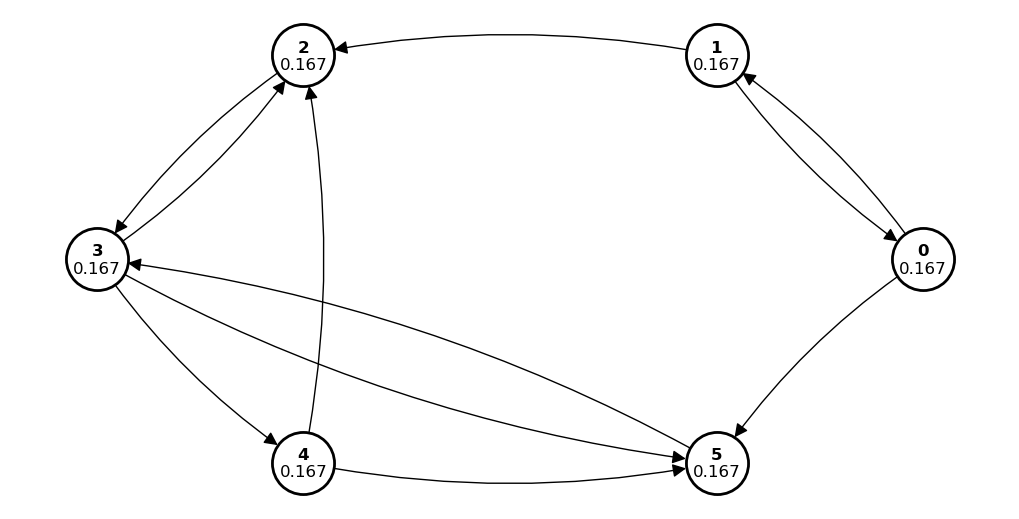

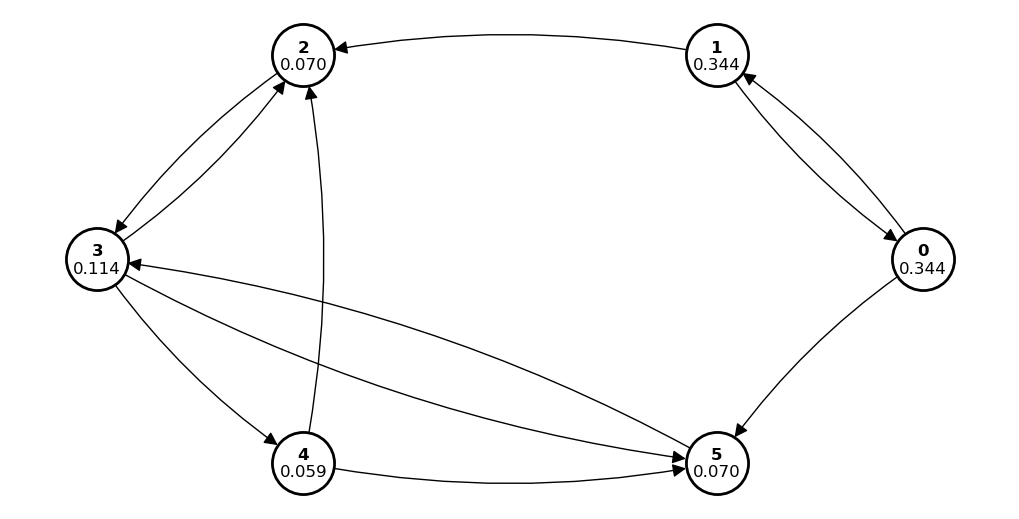

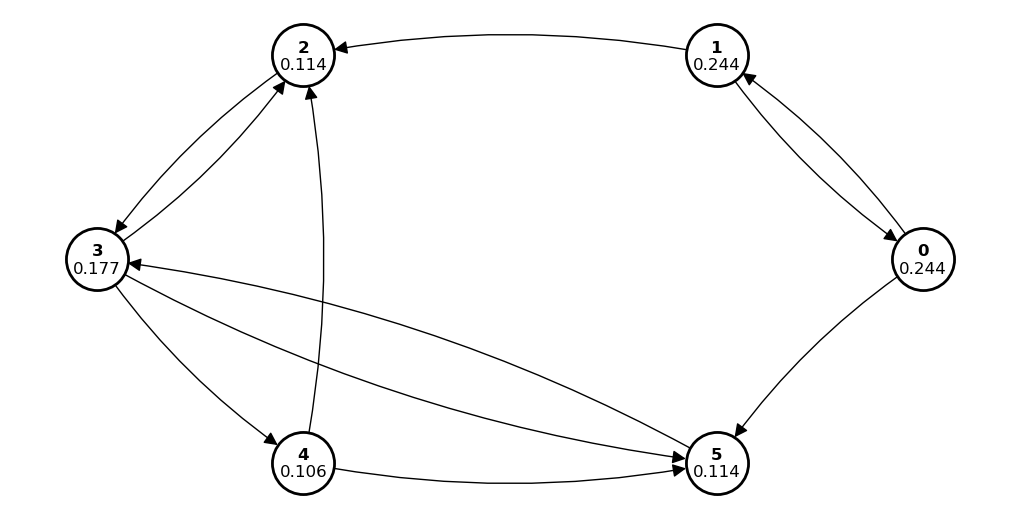

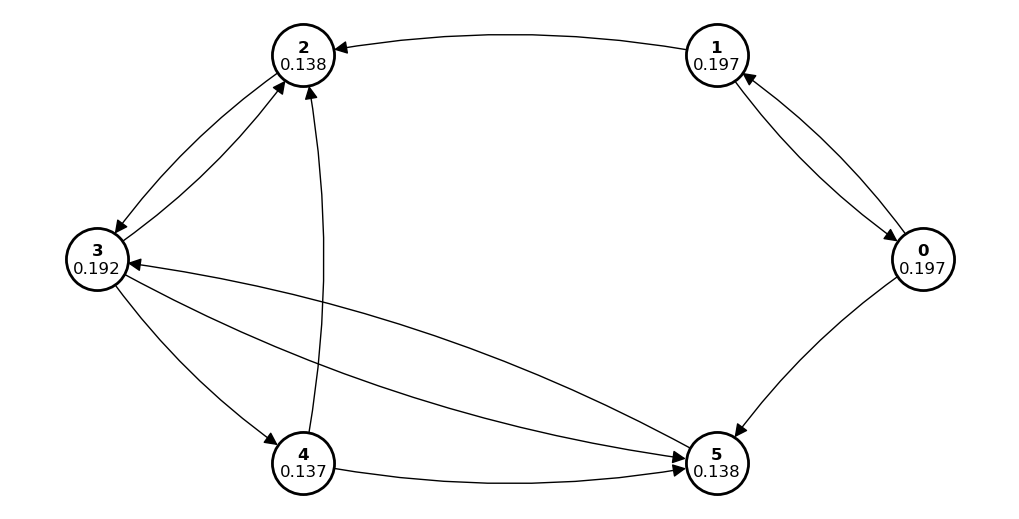

In [47]:
G = np.array([[0, 1, 0, 0, 0, 1],
              [1, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 1, 0, 1, 1],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],])

ranks = np.ones(G.shape[0])/G.shape[0]
plot_graph(G, ranks)

# ====================
alpha_values = [0.1, 0.33, 0.6]

# Test the modified algorithm with different alpha values
for alpha in alpha_values:
    ranks_alpha = PageRank_3(G, num_steps=10, ranks=ranks, alpha=alpha)
    display("alpha is: ", alpha)
    plot_graph(G, ranks_alpha)



'alpha is: '

0.1

'alpha is: '

0.33

'alpha is: '

0.9

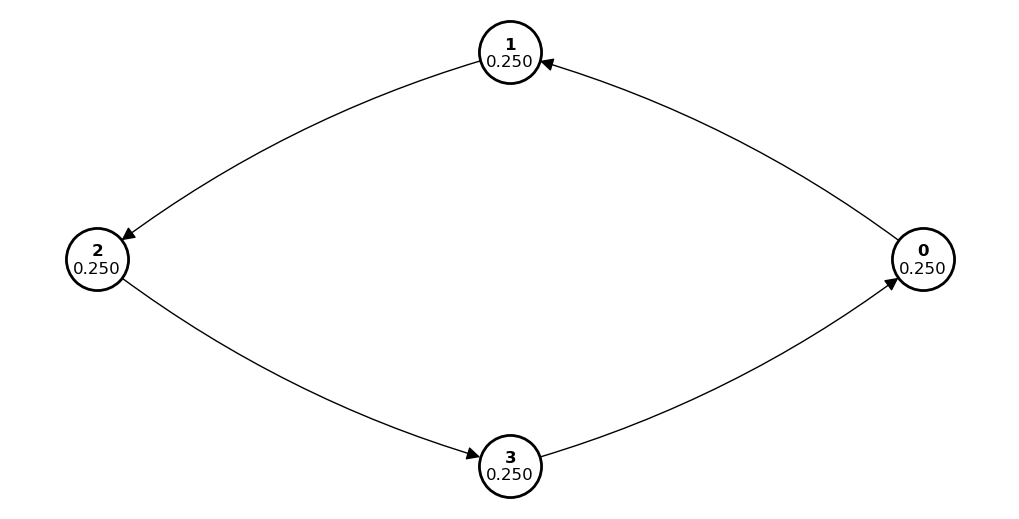

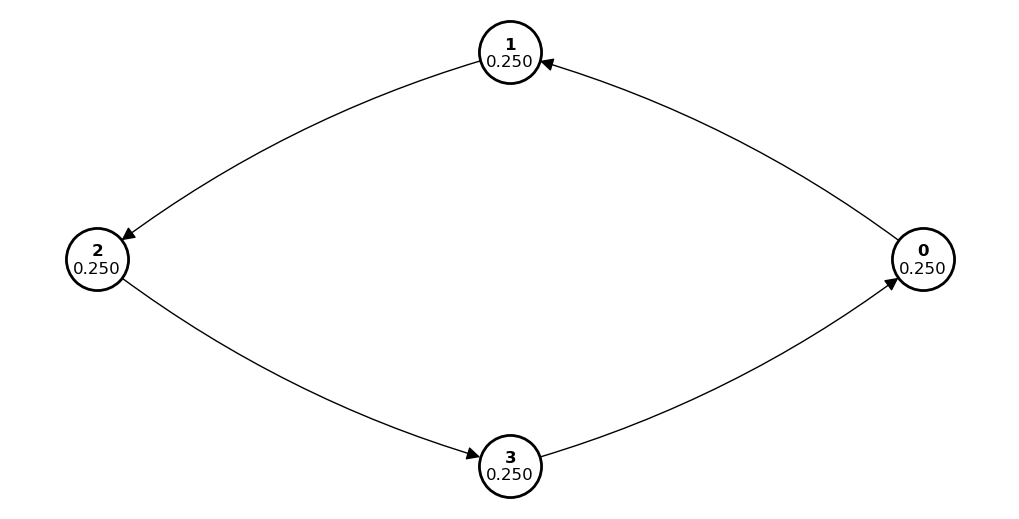

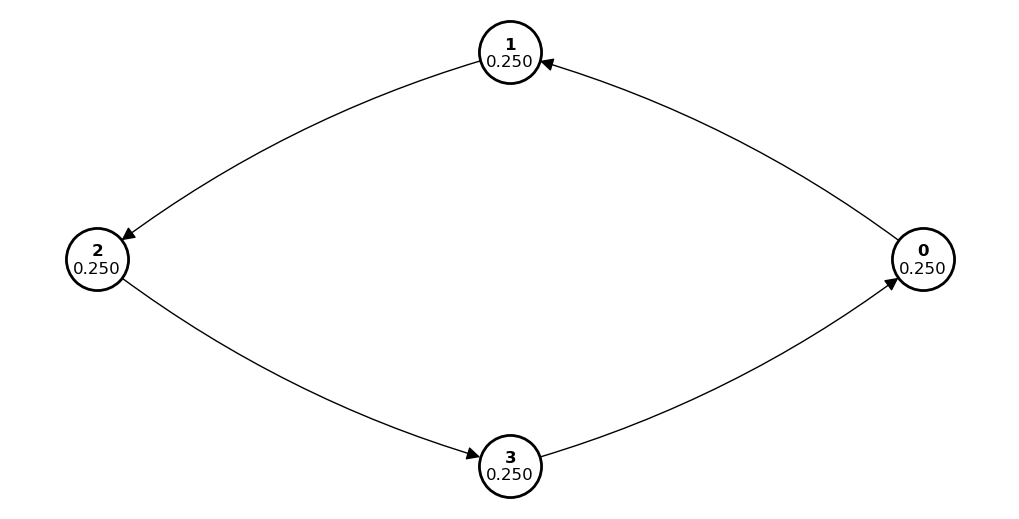

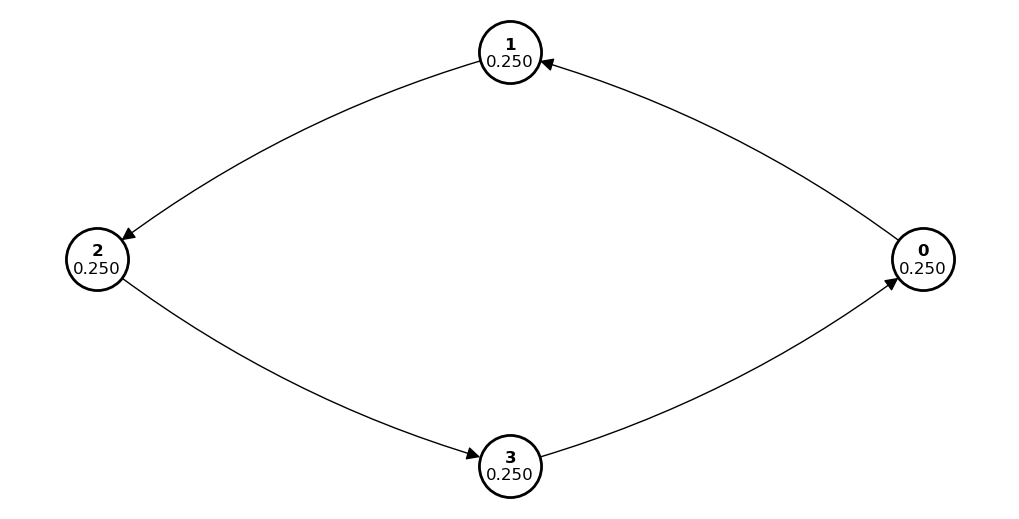

In [53]:
G = np.array([[0, 1, 0, 0, ],
              [0, 0, 1, 0, ],
              [0, 0, 0, 1, ],
              [1, 0, 0, 0, ]])
ranks = np.ones(G.shape[0])/G.shape[0]
plot_graph(G, ranks)
# ====================
alpha_values = [0.1, 0.33, 0.9]

# Test the modified algorithm with different alpha values
for alpha in alpha_values:
    ranks_alpha = PageRank_3(G, num_steps=15, ranks=ranks, alpha=alpha)
    display("alpha is: ", alpha)
    plot_graph(G, ranks_alpha)


---

With implemented random jumps from node to node, we may see improved convergence, especially when dealing with dead or one-way nodes, this can be double-checked if we would run the algorithm on a following matrix:
Furthermore, we can see that the final node got meaningful ranking. Such augmentation should potentially help in scenarios where nodes have limited connections.

---

'alpha is: '

0.1

'alpha is: '

0.33

'alpha is: '

0.9

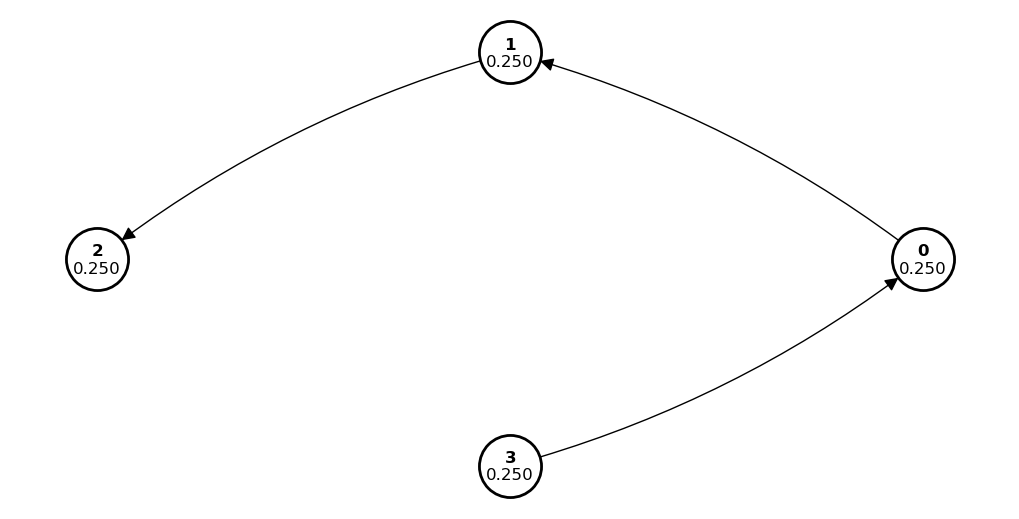

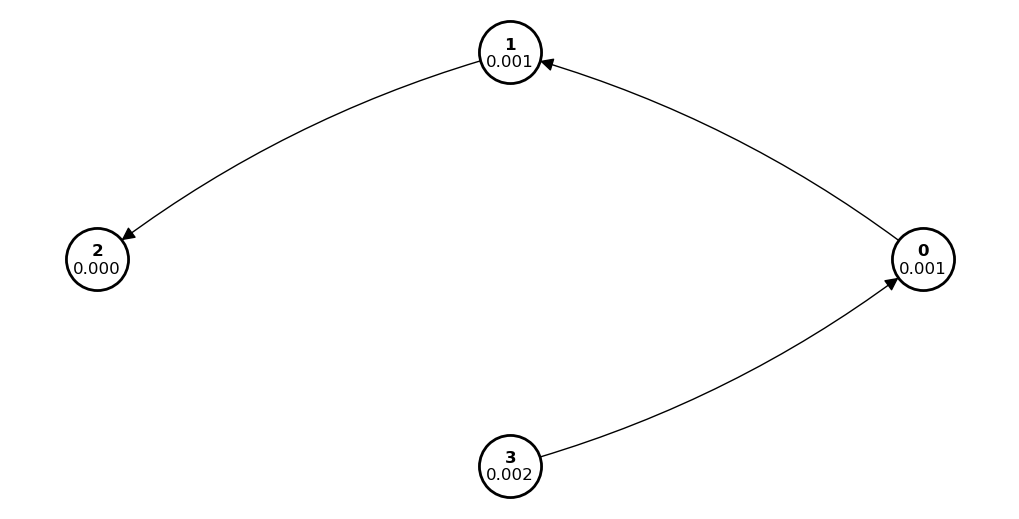

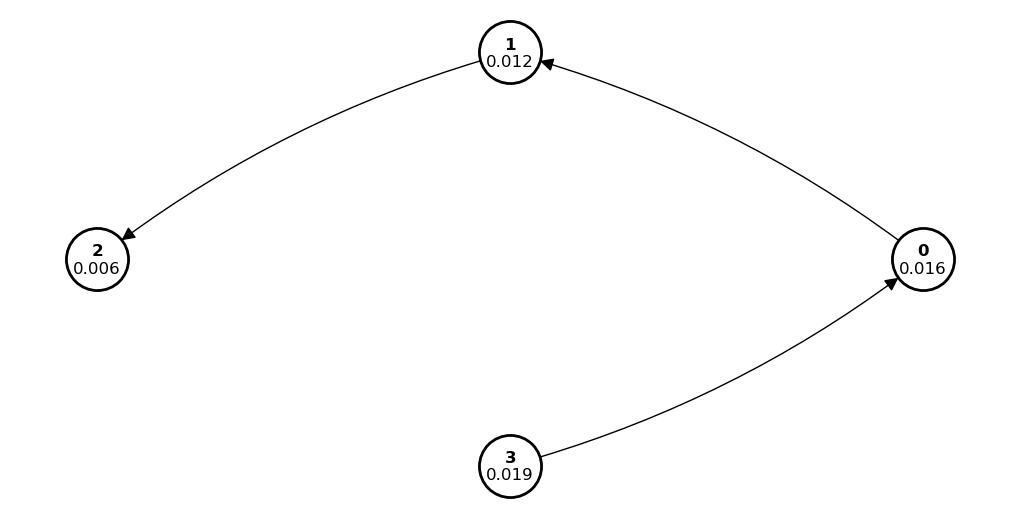

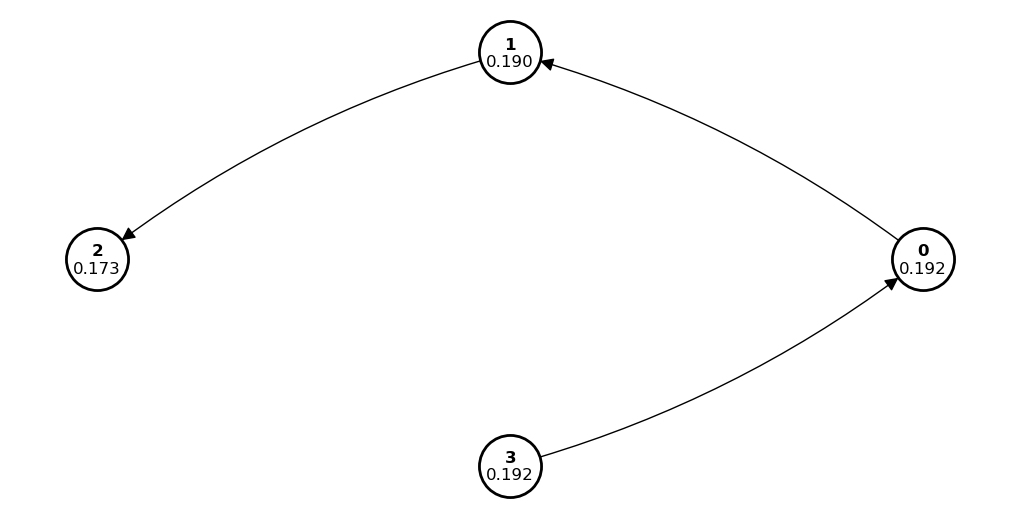

In [59]:
G = np.array([[0, 1, 0, 0, ],
              [0, 0, 1, 0, ],
              [0, 0, 0, 0, ],
              [1, 0, 0, 0, ]])
ranks = np.ones(G.shape[0])/G.shape[0]
plot_graph(G, ranks)
# ====================
alpha_values = [0.1, 0.33, 0.9]

# Test the modified algorithm with different alpha values
for alpha in alpha_values:
    ranks_alpha = PageRank_3(G, num_steps=15, ranks=ranks, alpha=alpha)
    display("alpha is: ", alpha)
    plot_graph(G, ranks_alpha)


## **4. PageRank on moderate-sized graphs (0.5 pt)**
<!-- Which metrics can be used to analyze performance on large graphs? -->
####Randomly generate adjacency matrix for a moderate-sized graph (~100 nodes); remember to remove the diagonal entries. Test how different choices of $\alpha$ and different iteration counts affect the results. Summarize your findings below

/Users/rkovalch/miniconda3/envs/cv-labs/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


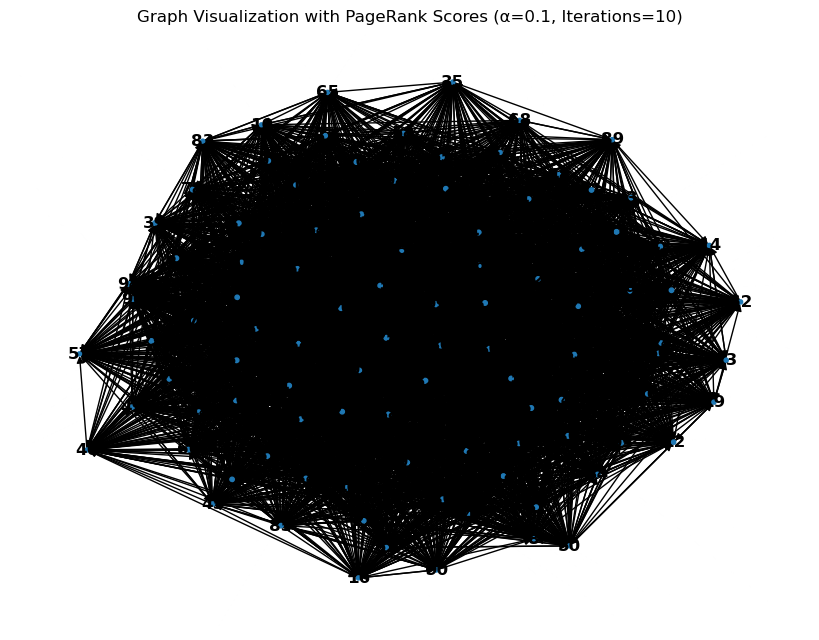

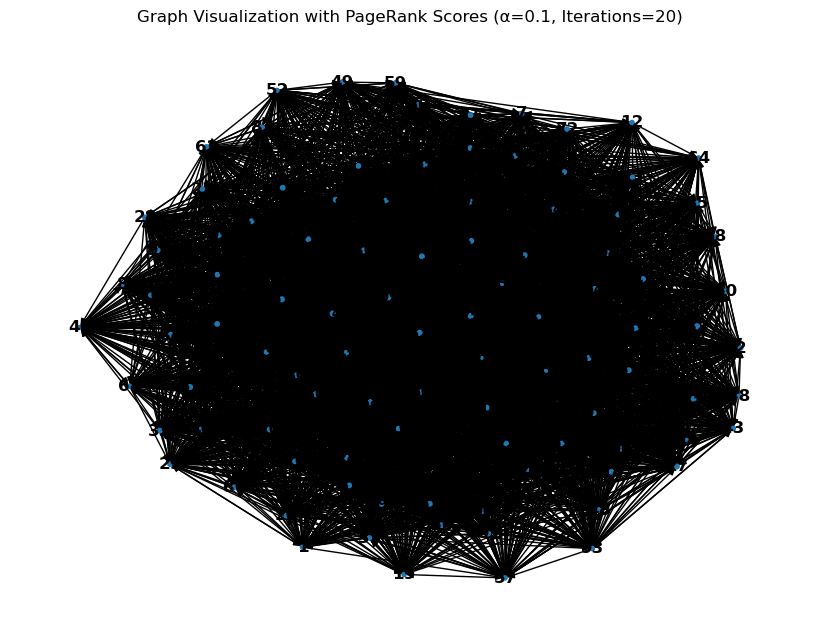

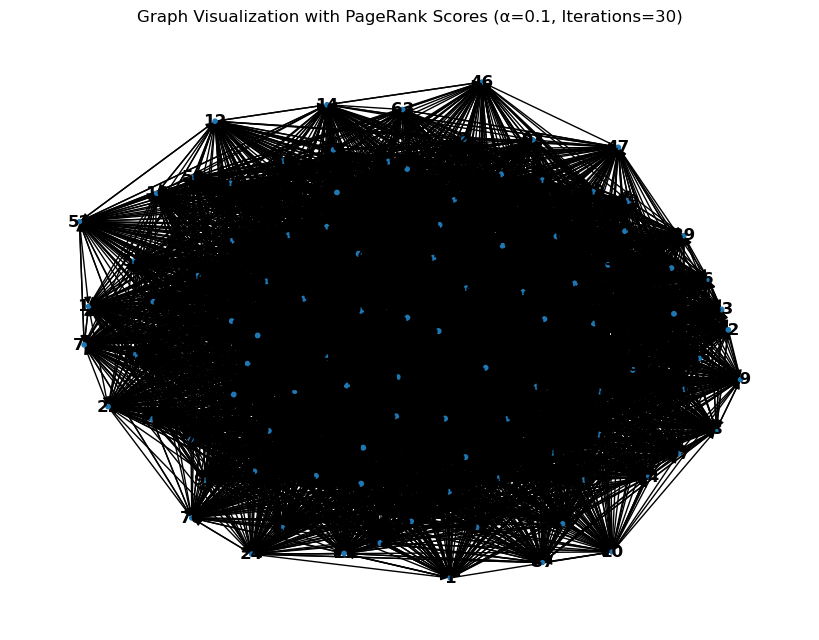

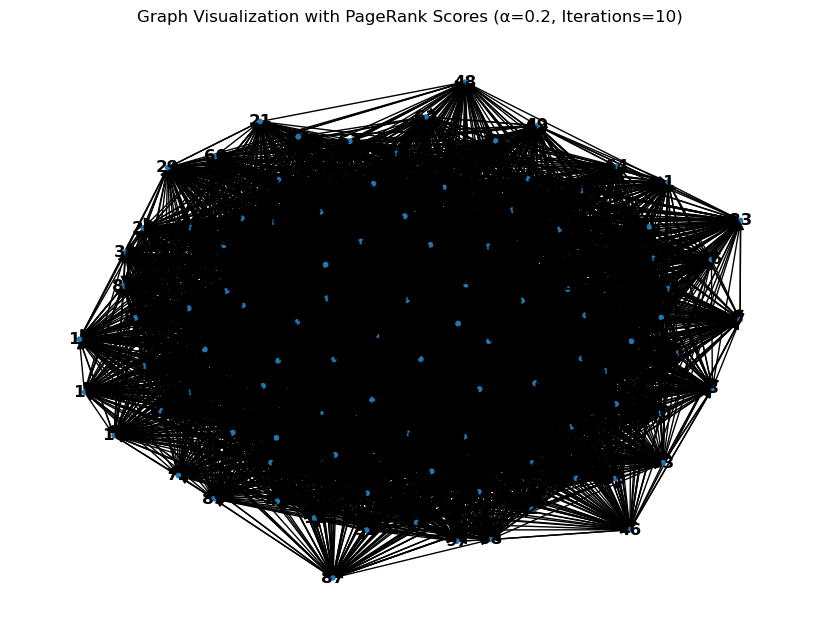

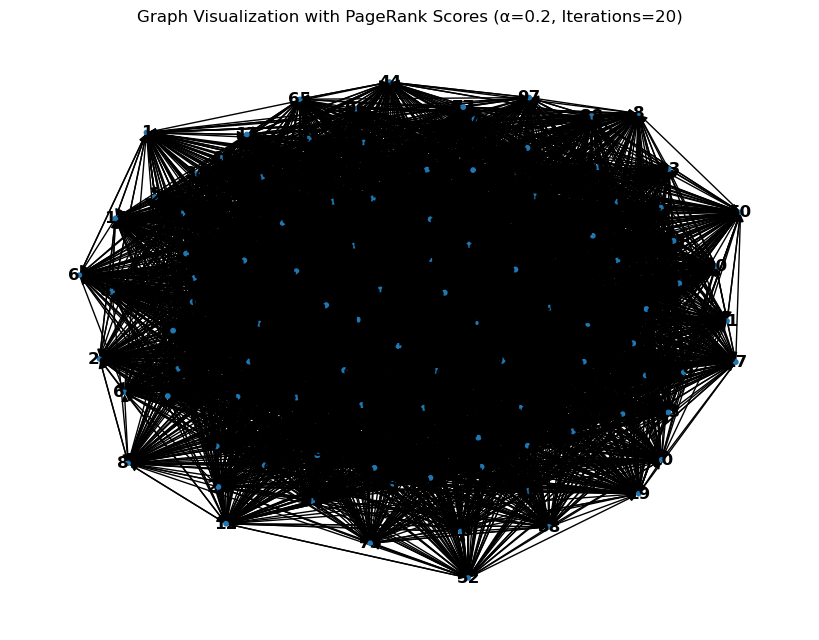

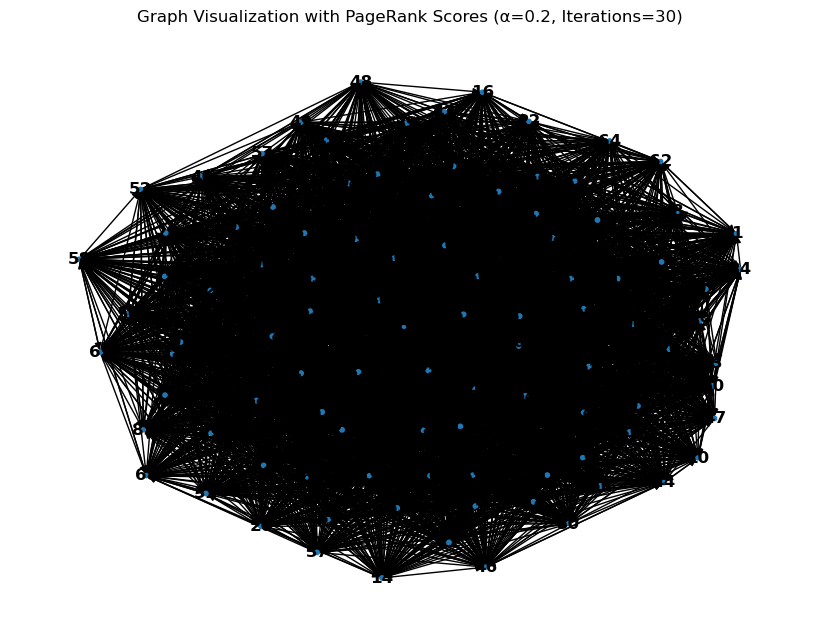

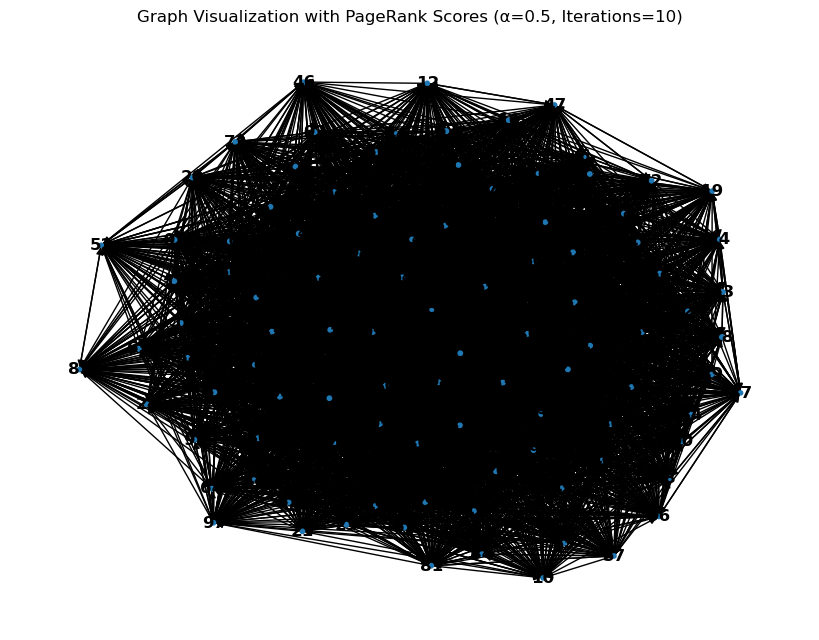

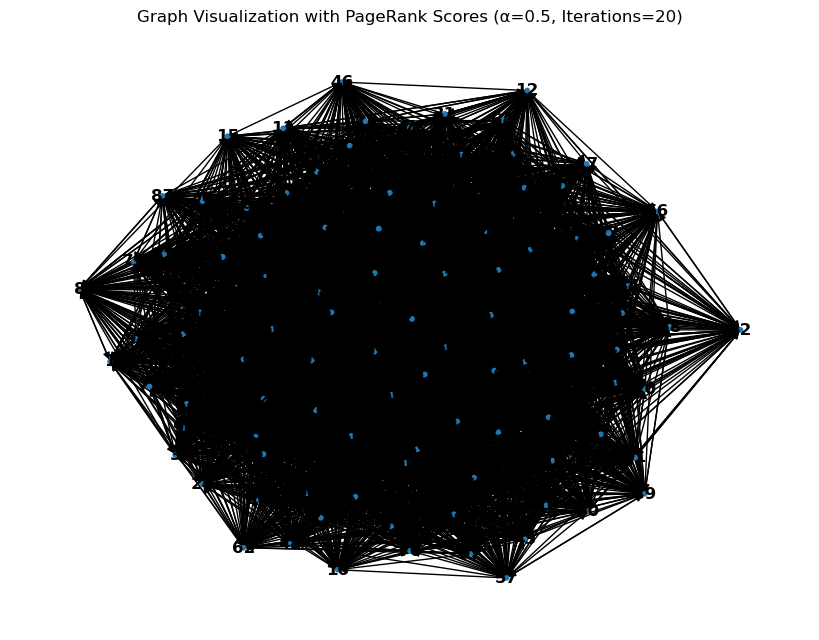

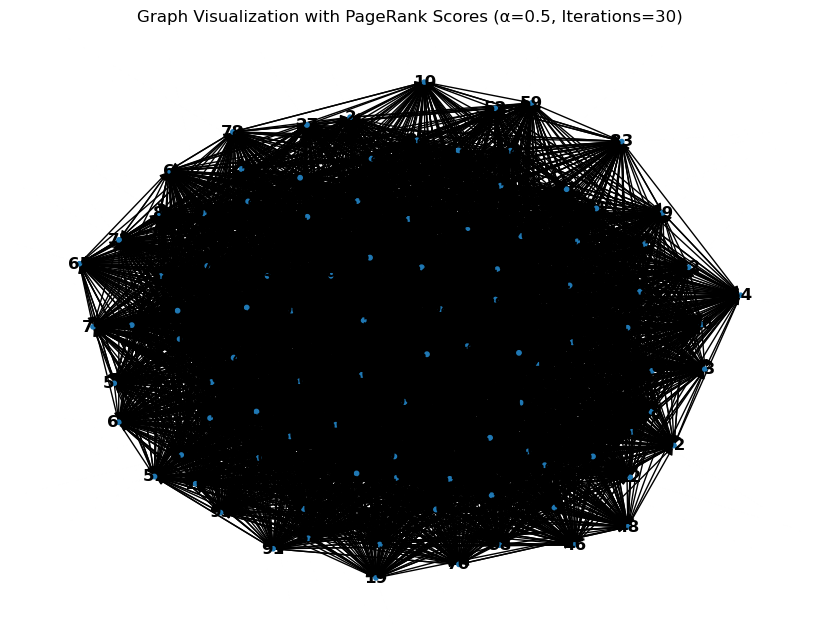

In [58]:
# ====================
def generate_random_graph(num_nodes):
    # Generate a random adjacency matrix for a directed graph
    np.random.seed(42)
    G = np.random.randint(2, size=(num_nodes, num_nodes))
    np.fill_diagonal(G, 0)  # Remove diagonal entries
    return G

def plot_graph_2(G, ranks, alpha, num_steps):
    # Visualize the graph with node sizes proportional to PageRank scores
    plt.figure(figsize=(8, 6))
    graph = nx.DiGraph(np.array(G))
    pos = nx.spring_layout(graph)
    node_size = 1000 * ranks  # Adjusting node size based on PageRank scores
    nx.draw(graph, pos, with_labels=True, node_size=node_size, cmap=plt.cm.Blues, font_weight='bold')
    plt.title(f"Graph Visualization with PageRank Scores (α={alpha}, Iterations={num_steps})")
    plt.show()


def analyze_pagerank_performance(num_nodes=100):
    # Generate a random graph
    G = generate_random_graph(num_nodes)

    # Initial rank distribution
    ranks = np.ones(num_nodes) / num_nodes

    # Test different alpha values and iteration counts
    alpha_values = [0.1, 0.2, 0.5]
    iteration_counts = [10, 20, 30]

    for alpha in alpha_values:
        for num_steps in iteration_counts:
            ranks_alpha = PageRank_3(G, num_steps=num_steps, ranks=ranks, alpha=alpha)
            plot_graph_2(G, ranks_alpha, alpha, num_steps)

# Uncomment the next line to run the analysis
analyze_pagerank_performance(num_nodes=100)


---

To analyze the performance of the PageRank algorithm on a moderate-sized graph (~100 nodes), we can randomly generate an adjacency matrix and test different choices of
α and iteration counts. The choice of performance metrics for large graphs can include convergence speed, stability of PageRank scores, and the impact of
α on the results.

During this lab I've learned how to implement page rank algorithm, its setbacks, possible augmentations to resolve them, such as dead nodes, or nodes with limited connectivity.
Potentially pagerank algorithm is a very powerful tool for establishing connections measure between the nodes, with minimal number of unnecessary computations and check on nodes
(as we could have seen in other graph algorithms, due to their complexity increase with size)

---